C:\Users\2013r\AppData\Local\Temp\ipykernel_29236\2607285729.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\2013r\AppData\Local\Temp\ipykernel_29236\2607285729.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


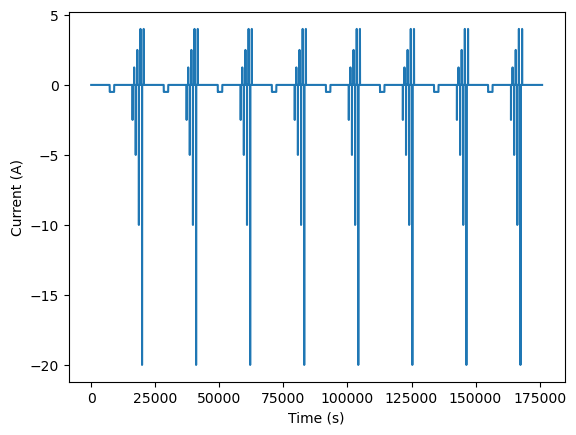

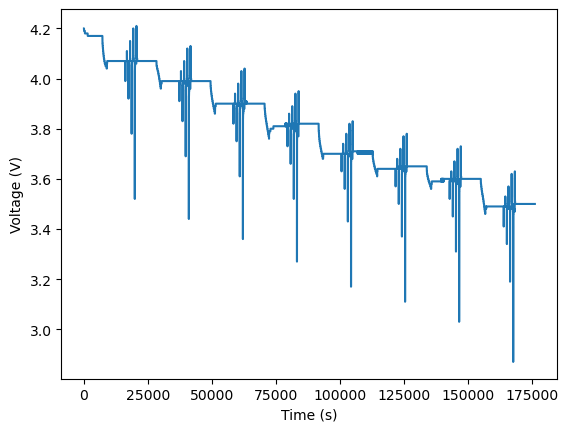

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io
import pandas as pd
import seaborn as sns

df1 = pd.read_csv('./data/Model_Training_Data_20.csv')

time = np.array(df1['Time (s)'][:])
current = np.array(df1['Current (A)'][:])
voltage = np.array(df1['Voltage (V)'][:])

fig, ax = plt.subplots()
ax.plot(time,current)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')
#ax.set_xlim(16000,16200)
fig.show()

fig, ax = plt.subplots()
ax.plot(time,voltage)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
#ax.set_xlim(16000,16200)
#ax.set_ylim(3.8,4.2)
fig.show()

In [2]:
# identify pulse

# find indices for non-zero current
nonzero_current_indices = np.array(np.nonzero(current))
nonzero_current_indices = nonzero_current_indices[0]

# identify start and end of each current pulse
starting_indices = np.array([])
starting_indices = np.append(starting_indices, nonzero_current_indices[0])
ending_indices = np.array([])

for i in range(1,len(nonzero_current_indices)):
  if nonzero_current_indices[i] - nonzero_current_indices[i-1] > 1:
    starting_indices = np.append(starting_indices, nonzero_current_indices[i])
  if nonzero_current_indices[i] - nonzero_current_indices[i-1] > 1:
    ending_indices = np.append(ending_indices, nonzero_current_indices[i-1])
ending_indices = np.append(ending_indices,nonzero_current_indices[-1])
starting_indices = starting_indices.astype(int)
ending_indices = ending_indices.astype(int)

print(starting_indices)
print(ending_indices)

[  7201  16142  22244  28446  34548  40750  46852  53104  59206  72909
  81850  87952  94154 100256 106458 112560 118812 124914 138617 147558
 153660 159862 165964 172166 178268 184520 190622 204325 213266 219368
 225570 231672 237874 243976 250228 256330 270033 278974 285076 291278
 297380 303582 309684 315936 322038 335741 344683 350785 356987 363089
 369291 375393 381645 387747 401450 410391 416493 422695 428797 434999
 441101 447353 453455 467158 476099 482201 488403 494505 500707 506809
 513061 519163]
[  8940  16242  22444  28546  34748  40850  47102  53204  59706  74648
  81950  88152  94254 100456 106558 112810 118912 125414 140356 147658
 153860 159962 166164 172266 178518 184620 191122 206064 213366 219568
 225670 231872 237974 244226 250328 256830 271772 279074 285276 291378
 297580 303682 309934 316036 322538 337481 344783 350985 357087 363289
 369391 375643 381745 388247 403189 410491 416693 422795 428997 435099
 441351 447453 453955 468897 476199 482401 488503 494705 5008

In [12]:
# identify current magnitude for each pulse
current_mag = current[ending_indices]
print(current_mag)

# identify starting voltages before each current pulse
starting_voltages = np.zeros(len(starting_indices))
for i in range(0,len(starting_indices)):
  starting_voltages[i] = voltage[starting_indices[i]-1]
print(starting_voltages)

# identify voltages at the end of each current pulse
ending_voltages = np.zeros(len(ending_indices))
for i in range(0,len(ending_indices)):
  ending_voltages[i] = voltage[ending_indices[i]]
print(ending_voltages)

# identify immediate jump in voltage = R0 * current_mag
jumped_voltage = np.zeros(len(ending_indices))
for i in range(0,len(ending_indices)):
  jumped_voltage[i] = voltage[ending_indices[i]+1]
voltage_jump = ending_voltages - jumped_voltage
print(voltage_jump)

# calculate R0
R0 = voltage_jump / current_mag

# steady state voltage = (R0 + R1) * current_mag
# steady state voltage is the same as the start voltage of the next pulse
voltage_ss = np.zeros(len(starting_indices))
for i in range(0,len(starting_voltages)-1):
  voltage_ss[i] = starting_voltages[i+1]
voltage_ss[-1] = voltage[-1]
voltage_inf = abs(voltage_ss - ending_voltages)
print(voltage_inf)

# calculate R1
R1 = (voltage_inf / abs(current_mag)) - R0
print(R1)

# want to find how long it takes for voltage to reach steady state once current pulse ends, to find 4R1C1
index_ss = np.zeros(len(ending_indices))
for i in range(0,len(ending_indices)):
  for j in range(ending_indices[i],len(time)):
    if voltage[j] == voltage_ss[i]:
      index_ss[i] = j
      break
index_ss = index_ss.astype(int)

time_ss = time[index_ss]
end_time = time[ending_indices]
relax_time = time_ss - end_time

# calculate time constant and C1
time_constant = relax_time / 4
C1 = time_constant / R1


[ -0.5    -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.
  -0.499  -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.
  -0.498  -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.
  -0.499  -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.
  -0.499  -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.
  -0.499  -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.
  -0.499  -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.
  -0.499  -2.5     1.25   -5.      2.5   -10.      4.    -20.      4.   ]
[4.17 4.07 4.07 4.07 4.07 4.07 4.07 4.07 4.06 4.07 3.99 3.99 3.99 3.98
 3.99 3.98 3.99 3.96 3.99 3.9  3.9  3.9  3.9  3.9  3.89 3.9  3.88 3.9
 3.82 3.81 3.82 3.8  3.82 3.79 3.82 3.77 3.82 3.7  3.7  3.7  3.7  3.7
 3.69 3.7  3.68 3.71 3.64 3.64 3.64 3.64 3.64 3.64 3.65 3.63 3.65 3.6
 3.59 3.6  3.59 3.6  3.58 3.6  3.57 3.6  3.49 3.49 3.49 3.49 3.49 3.48
 3.5  3.48]
[4.04 3.99 4.11 3.92 4.15 3.78 4.2  3.52 4.21 3.96 3.91 4.03 3.83 4.07
 

In [141]:
SoC = np.array([0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2])

current_mag_matrix = np.reshape(current_mag,(8,9))
R0_matrix = np.reshape(R0,(8,9))
R1_matrix = np.reshape(R1,(8,9))
C1_matrix = np.reshape(C1,(8,9))
time_constant_matrix = np.reshape(time_constant,(8,9))

from tabulate import tabulate

current_mag_matrix = current_mag_matrix[:, 1:]
R0_matrix = R0_matrix[:, 1:]
R1_matrix = R1_matrix[:, 1:]
C1_matrix = C1_matrix[:, 1:]
time_constant_matrix = time_constant_matrix[:, 1:]

current_mag_vector = current_mag_matrix[0]

print('R0: ',R0_matrix)
print('R1: ',R1_matrix)
print('C1: ',C1_matrix)
print('Currents: ',current_mag_vector)
print('SoCs: ',SoC)


R0:  [[0.024  0.016  0.02   0.02   0.02   0.02   0.019  0.02  ]
 [0.02   0.016  0.02   0.02   0.02   0.02   0.0185 0.02  ]
 [0.02   0.016  0.018  0.02   0.019  0.02   0.0185 0.02  ]
 [0.02   0.024  0.02   0.016  0.02   0.02   0.019  0.02  ]
 [0.02   0.016  0.02   0.02   0.02   0.0175 0.0195 0.0175]
 [0.02   0.016  0.02   0.02   0.02   0.02   0.0195 0.0175]
 [0.02   0.016  0.02   0.02   0.021  0.02   0.0205 0.02  ]
 [0.024  0.016  0.022  0.02   0.022  0.02   0.0225 0.02  ]]
R1:  [[0.008  0.016  0.01   0.012  0.009  0.0125 0.008  0.015 ]
 [0.012  0.016  0.01   0.012  0.009  0.0125 0.0075 0.015 ]
 [0.012  0.016  0.012  0.012  0.009  0.0125 0.0075 0.015 ]
 [0.012  0.008  0.008  0.012  0.007  0.01   0.006  0.0125]
 [0.008  0.016  0.008  0.012  0.006  0.0125 0.006  0.0125]
 [0.008  0.016  0.008  0.012  0.007  0.01   0.0065 0.0125]
 [0.008  0.008  0.008  0.008  0.006  0.01   0.0065 0.0125]
 [0.008  0.016  0.008  0.012  0.007  0.01   0.008  0.0125]]
C1:  [[  802.9375       560.8125      1429.9

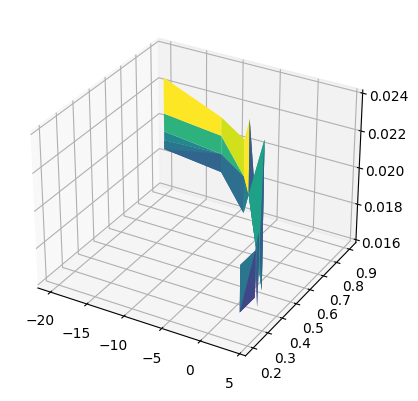

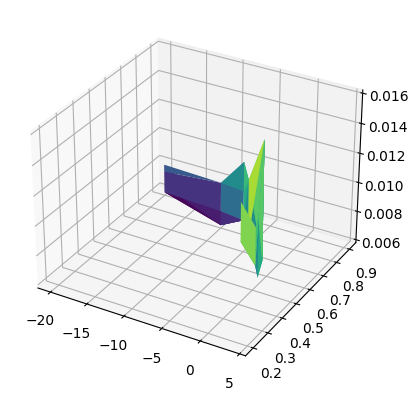

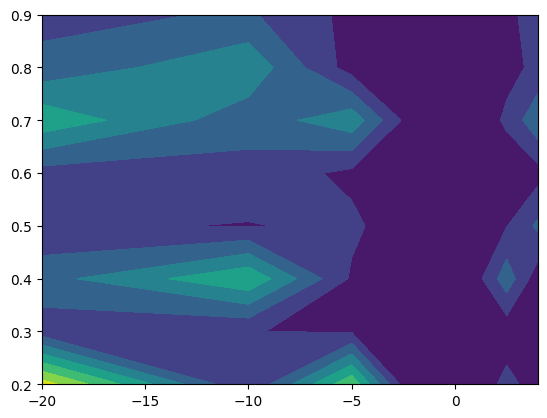

In [142]:
# Sort x values and corresponding z values
sorted_indices = np.argsort(current_mag_vector)
sorted_current_mag_vector = current_mag_vector[sorted_indices]
sorted_R0 = R0_matrix[:, sorted_indices]
sorted_R1 = R1_matrix[:, sorted_indices]
sorted_C1 = C1_matrix[:, sorted_indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(sorted_current_mag_vector, SoC,sorted_R0, cmap='viridis')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(sorted_current_mag_vector, SoC,sorted_R1, cmap='viridis')

fig = plt.figure()
ax = fig.add_subplot(111)
surf = ax.contourf(sorted_current_mag_vector, SoC,sorted_C1, cmap='viridis')